import Python libraries

In [91]:
%matplotlib inline
import matplotlib
import matplotlib.pyplot as plt

import numpy as np
import pandas as pd
import json
import scipy
import time
from sklearn import metrics
import implicit
from implicit.evaluation import precision_at_k, train_test_split

Read training data from file

In [2]:
with open('training_mixpanel.txt') as f:
    data = json.loads(f.read())

In [3]:
type(data)

list

Since this data is list, let's print the first element of this list to check its contents

In [4]:
data[0]

{'event': 'Purchased Product',
 'properties': {'country': 'United Kingdom',
  'customer_id': 17850,
  'description': 'WHITE HANGING HEART T-LIGHT HOLDER',
  'invoice_date': '12/1/2010 8:26',
  'invoice_no': '536365',
  'product_id': '85123A',
  'quantity': 6,
  'unit_price': 2.55}}

Each element in `data` is a dictionary having details of an event and its properties. Let's see how many different events we have.

In [5]:
event_types = set()
for item in data:
    event_types.add(item['event'])
print(event_types)

{'Purchased Product'}


All events are purchase history of products. Let's convert this json data to a Pandas dataframe.

In [6]:
df = pd.DataFrame(data=[event['properties'] for event in data])

In [11]:
df.head()

,country,customer_id,description,invoice_date,invoice_no,product_id,quantity,unit_price
0,United Kingdom,17850,WHITE HANGING HEART T-LIGHT HOLDER,2010-12-01 08:26:00,536365,85123A,6,2.55
1,United Kingdom,17850,WHITE METAL LANTERN,2010-12-01 08:26:00,536365,71053,6,3.39
2,United Kingdom,17850,SET 7 BABUSHKA NESTING BOXES,2010-12-01 08:26:00,536365,22752,2,7.65
3,United Kingdom,17850,GLASS STAR FROSTED T-LIGHT HOLDER,2010-12-01 08:26:00,536365,21730,6,4.25
4,United Kingdom,17850,HAND WARMER UNION JACK,2010-12-01 08:28:00,536366,22633,6,1.85


In [7]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 322875 entries, 0 to 322874
Data columns (total 8 columns):
country         322875 non-null object
customer_id     322875 non-null int64
description     322875 non-null object
invoice_date    322875 non-null object
invoice_no      322875 non-null object
product_id      322875 non-null object
quantity        322875 non-null int64
unit_price      322875 non-null float64
dtypes: float64(1), int64(2), object(5)
memory usage: 19.7+ MB


- None of the values are Null so we don't have to fill/replace null values.
- invoice_date is stored as object (i.e. string). We are going to use datetime later, so let's convert it from string to datetime objects. This operation is quite slow and takes time.

In [8]:
df['invoice_date'] = df['invoice_date'].apply(pd.to_datetime)

In [9]:
df.describe()

,customer_id,quantity,unit_price
count,322875.000000,322875.000000,322875.000000
mean,15285.738180,12.103250,2.934132
std,1712.664883,278.315144,6.228682
min,12346.000000,-80995.000000,0.000000
25%,13952.000000,2.000000,1.250000
50%,15150.000000,5.000000,1.950000
75%,16788.000000,12.000000,3.750000
max,18287.000000,80995.000000,1100.440000


Minimum value of quantity is a negative which indicates that there are returned orders too.

In [24]:
print('total number of return transactions: ', 
      df.quantity[df.quantity < 0].count())
print('total number of customer visits when products were returned: ', 
      df.invoice_no[df.quantity < 0].unique().shape[0])

total number of return transactions:  6920
total number of customer visits when products were returned:  3010


In [17]:
df.head()

,country,customer_id,description,invoice_date,invoice_no,product_id,quantity,unit_price
0,United Kingdom,17850,WHITE HANGING HEART T-LIGHT HOLDER,2010-12-01 08:26:00,536365,85123A,6,2.55
1,United Kingdom,17850,WHITE METAL LANTERN,2010-12-01 08:26:00,536365,71053,6,3.39
2,United Kingdom,17850,SET 7 BABUSHKA NESTING BOXES,2010-12-01 08:26:00,536365,22752,2,7.65
3,United Kingdom,17850,GLASS STAR FROSTED T-LIGHT HOLDER,2010-12-01 08:26:00,536365,21730,6,4.25
4,United Kingdom,17850,HAND WARMER UNION JACK,2010-12-01 08:28:00,536366,22633,6,1.85


Since we do not have explicit ratings for items, 
we will use implicit collaborative filtering method for recommendations as described by ..........
Purchase history contains information about item-item, user-user similarity as well as user-item affinity. We know that there are certain factors which result into a user purchasing item A and not B but we do not know exactly which factors. We will assume that are latent factors and solve the user-item affinity matrix using matrix factorization. Now this user-item affinity matrix has confidence values as weights. Confidence values can be either purchase quantity, user clicks or anything else which represents the user-item interaction.

*Purchase quantity* is a good indicator of customer's likeness for a product so we can use this as confidence value in our user-item matrix.
But we will use *purchase frequency* of a product by a customer as our confidence value.
The reason is that there are greater chances of cross-sales for a frequent customer than less frequent one even when they are purchasing equal quantity of any specific item.

To be precise, for each customer (c) and product (p):

purchase_frequency = (total purchased - total returned)/(latest invoice date - first invoice date)

In [25]:
g = df.groupby(['customer_id', 'product_id'])

In [59]:
final_data = g[['quantity']].sum()  # add quantities of each user, item pair

In [60]:
final_data.head()

quantity
customer_id product_id          
12346       23166              0
12347       16008             24
            17021             36
            20665              6
            20719             40

In [61]:
final_data.describe()

,quantity
count,213661.000000
mean,18.289894
std,98.772516
min,-9360.000000
25%,2.000000
50%,6.000000
75%,12.000000
max,12540.000000


Minimum of sum(quantity) is negative which means there are records of users returning certain items but there are no corresponding records of sales.
We will drop these events where total quantity is not positive.

In [62]:
final_data = final_data[final_data.quantity > 0]

In [63]:
final_data.describe()

,quantity
count,211749.000000
mean,18.532711
std,97.030306
min,1.000000
25%,2.000000
50%,6.000000
75%,12.000000
max,12540.000000


In [64]:
# For each user, item pair find time difference between latest and first transaction.
final_data['time_delta'] = g[['invoice_date']].max() - g[['invoice_date']].min()

In [65]:
# Convert time delta to days
final_data['days'] = final_data['time_delta'].dt.days

In [66]:
final_data.head()

quantity        time_delta  days
customer_id product_id                                  
12347       16008             24   0 days 00:00:00     0
            17021             36   0 days 00:00:00     0
            20665              6   0 days 00:00:00     0
            20719             40 315 days 01:22:00   315
            20780             12   0 days 00:00:00     0

- If an item is purchased only once, this value will be zero. If an item is only purchased on 1 day, even if there are multiple interactions, this value will be zero.
- We will assume that for both these cases items were purchased just once in total time interval difference between first and last transaction for all items i.e. maximum value of time difference across all items.

In [67]:
tdelta_max = final_data['time_delta'].max().days
final_data.loc[final_data['days']==0, 'days'] = tdelta_max

In [68]:
final_data.head()

quantity        time_delta  days
customer_id product_id                                  
12347       16008             24   0 days 00:00:00   373
            17021             36   0 days 00:00:00   373
            20665              6   0 days 00:00:00   373
            20719             40 315 days 01:22:00   315
            20780             12   0 days 00:00:00   373

In [69]:
# Calculate purchase frequency per user, item pair
final_data['purchase_freq'] = final_data['quantity'] / final_data['days']

In [70]:
# Drop rows with NA or Null values
final_data.dropna(inplace=True)

In [71]:
customers = list(final_data.index.get_level_values('customer_id').unique())
products = list(final_data.index.get_level_values('product_id').unique())

In [72]:
final_data.reset_index(level=['customer_id', 'product_id'], inplace=True)

In [73]:
final_data.head()

,customer_id,product_id,quantity,time_delta,days,purchase_freq
0,12347,16008,24,0 days 00:00:00,373,0.064343
1,12347,17021,36,0 days 00:00:00,373,0.096515
2,12347,20665,6,0 days 00:00:00,373,0.016086
3,12347,20719,40,315 days 01:22:00,315,0.126984
4,12347,20780,12,0 days 00:00:00,373,0.032172


In [74]:
customer_indices = final_data['customer_id'].astype('category').cat.codes
product_indices = final_data['product_id'].astype('category').cat.codes

In [75]:
customer_indices.max()

4322

In [76]:
purchase_frequency = list(final_data['purchase_freq'])

In [77]:
final_data.describe()

,customer_id,quantity,time_delta,days,purchase_freq
count,211749.000000,211749.000000,211749,211749.000000,211749.000000
mean,15275.497287,18.532711,30 days 15:39:59.852939,318.226126,0.206489
std,1710.522199,97.030306,73 days 23:41:14.369887,111.459076,2.856226
min,12347.000000,1.000000,0 days 00:00:00,1.000000,0.002681
25%,13865.000000,2.000000,0 days 00:00:00,373.000000,0.005935
50%,15218.000000,6.000000,0 days 00:00:00,373.000000,0.023166
75%,16771.000000,12.000000,0 days 00:00:00,373.000000,0.064343
max,18287.000000,12540.000000,373 days 02:19:00,373.000000,601.000000


In [78]:
user_item_purchase = scipy.sparse.csr_matrix((purchase_frequency, (customer_indices, product_indices)), shape=(len(customers), len(products)))

In [79]:
user_item_purchase[user_item_purchase.nonzero()]

matrix([[0.06434316, 0.09651475, 0.01608579, ..., 0.01072386, 0.67605634,
         0.12868633]])

In [80]:
user_item_purchase.shape

(4323, 3642)

In [81]:
item_users = user_item_purchase.transpose()

In [82]:
item_users.shape

(3642, 4323)

how to choose alpha - https://github.com/benfred/implicit/issues/74

In [83]:
alpha = (user_item_purchase.shape[0] * user_item_purchase.shape[1] - user_item_purchase.nnz) / sum(user_item_purchase.data)

In [84]:
user_item_purchase = user_item_purchase*alpha

In [85]:
item_users = item_users*alpha

In [86]:
print(np.min(user_item_purchase), np.max(user_item_purchase))

0.0 213501.12448720125


In [87]:
model = implicit.als.AlternatingLeastSquares(factors=50, regularization=0.1, iterations=25, calculate_training_loss=True)

In [88]:
t1 = time.time()
model.fit(item_users)
t2 = time.time()

100%|██████████| 25.0/25 [00:10<00:00,  2.68it/s, loss=0.0235]


In [89]:
elapsed = t2 - t1

print(elapsed)

10.281869173049927


In [93]:
train, val = train_test_split(item_users)

In [94]:
model = implicit.als.AlternatingLeastSquares(factors=180, regularization=0.1, iterations=50, calculate_training_loss=True)
model.fit(train)

100%|██████████| 50.0/50 [00:22<00:00,  2.23it/s, loss=0.0102]


loss saturates at ~40-50 iterations, so there is no need to run for more than 50 iters
- factors=20, iterations=50, regularization=0.1, loss=0.03
- factors=40, iterations=50, regularization=0.1, loss=0.023
- factors=50, iterations=50, regularization=0.1, loss=0.021
- factors=60, iterations=50, regularization=0.1, loss=0.019
- factors=80, iterations=50, regularization=0.1, loss=0.0166
- factors=100, iterations=50, regularization=0.1, loss=0.0146
- factors=120, iterations=50, regularization=0.1, loss=0.0131
- factors=140, iterations=50, regularization=0.1, loss=0.0119
- factors=160, iterations=50, regularization=0.1, loss=0.0108
- factors=180, iterations=50, regularization=0.1, loss=0.01             - chosen
- factors=200, iterations=50, regularization=0.1, loss=0.009
- factors=400, iterations=50, regularization=0.1, loss=0.005

In [95]:
p = precision_at_k(model, train.T.tocsr(), val.T.tocsr(), K=10, num_threads=2)
print(p)

 92%|█████████▏| 3978/4323 [00:02<00:00, 1639.09it/s]

0.1525770712909441


In [96]:
ma_p = implicit.evaluation.mean_average_precision_at_k(model, train.T.tocsr(), val.T.tocsr(), K=10, num_threads=2)

 92%|█████████▏| 3978/4323 [00:02<00:00, 1603.96it/s]


In [99]:
assert np.count_nonzero(train.todense()) + np.count_nonzero(val.todense()) == np.count_nonzero(np.array(purchase_frequency)), "check train + test != total items"

In [100]:
user_vectors = model.user_factors
item_vectors = model.item_factors

In [101]:
print('user vectors: {}, item vectors: {}'.format(user_vectors.shape, item_vectors.shape))

user vectors: (4323, 180), item vectors: (3642, 180)


In [102]:
# user-item rating matrix
user_item_rating = np.dot(user_vectors, item_vectors.transpose())

In [103]:
val_user_items = val.todense().transpose()
val_user_items = np.asarray(val_user_items)
val_user_items[val_user_items!=0] = 1

In [104]:
predictions = np.zeros(val_user_items.shape, dtype=float)
for i in range(val_user_items.shape[0]):
    if np.sum(val_user_items[i, :]) != 0:
        predictions[i, :] = np.dot(user_vectors[i, :], item_vectors.transpose())

In [105]:
# Convert weights to binary values (1=purchased, 0=not-purchased)
actual = np.array(val_user_items, dtype=int)

In [106]:
fpr, tpr, ths = metrics.roc_curve(actual.ravel(), predictions.ravel())
roc_auc = metrics.auc(fpr, tpr)

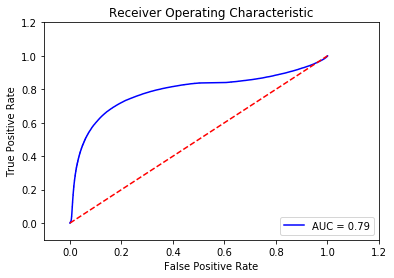

In [107]:
plt.title('Receiver Operating Characteristic')
plt.plot(fpr, tpr, 'b',
label='AUC = %0.2f'% roc_auc)
plt.legend(loc='lower right')
plt.plot([0,1],[0,1],'r--')
plt.xlim([-0.1,1.2])
plt.ylim([-0.1,1.2])
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.show()

In [109]:
model.explain

<bound method AlternatingLeastSquares.explain of <implicit.als.AlternatingLeastSquares object at 0x7f8e4b34cac8>>